In [29]:
INPUT_SHAPE = (224, 224, 3)
DATA_DIR = '/data/cmpe257-02-fa2019/team-1-meerkats/rsna-intracranial-hemorrhage-detection/'

In [2]:
!ls /data/cmpe257-02-fa2019/team-1-meerkats/weights/2019-12-04-01:23:28.857681-08:00-ResNet50-conv+head-670k

2019-12-04-01:23:28.857681-08:00-ResNet50-conv+head-670k-epoch=01-valid-loss=0.07.hdf5
2019-12-04-01:23:28.857681-08:00-ResNet50-conv+head-670k-epoch=02-valid-loss=0.06.hdf5
2019-12-04-01:23:28.857681-08:00-ResNet50-conv+head-670k-epoch=03-valid-loss=0.06.hdf5
2019-12-04-01:23:28.857681-08:00-ResNet50-conv+head-670k-epoch=04-valid-loss=0.06.hdf5


In [14]:
weights_file = '/data/cmpe257-02-fa2019/team-1-meerkats/weights/2019-12-04-01:23:28.857681-08:00-ResNet50-conv+head-670k/2019-12-04-01:23:28.857681-08:00-ResNet50-conv+head-670k-epoch=04-valid-loss=0.06.hdf5'
weights_file = '../2019-12-04-01:23:28.857681-08:00-ResNet50-conv+head-670k-epoch=04-valid-loss=0.06.hdf5'

In [24]:
# custom loss function
from keras import backend as K

def weighted_log_loss(y_true, y_pred):
    """
    Can be used as the loss function in model.compile()
    ---------------------------------------------------
    """
    
    class_weights = np.array([1., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    out = -(         y_true  * K.log(      y_pred) * class_weights
            + (1.0 - y_true) * K.log(1.0 - y_pred) * class_weights)
    
    return K.mean(out, axis=-1)

# custom performance metric
def correct_diagnoses(y_true, y_pred):
    THRESHOLD = 0.5
    p_thr = K.greater(y_pred, THRESHOLD)
    y_true = K.cast(y_true, dtype='bool')
    
    equals_t = K.equal(p_thr, y_true)
    correct_rows = K.all(equals_t, axis=1)
    correct_rows_int = K.cast(correct_rows, dtype='int32')
    
    return K.sum(correct_rows_int)/K.shape(correct_rows_int)[0]

def correct_positive_diagnoses(y_true, y_pred):
    THRESHOLD = 0.5
    p_thr = K.greater(y_pred, THRESHOLD)
    y_true = K.cast(y_true, dtype='bool')
    
    pos_mask = K.any(y_true, axis=1) #patients with positive diagnoses
    p_thr = p_thr[pos_mask]
    y_true = y_true[pos_mask]
    
    equals_t = K.equal(p_thr, y_true)
    correct_rows = K.all(equals_t, axis=1)
    correct_rows_float = K.cast(correct_rows, dtype='float32')
    
    return K.sum(correct_rows_float)/(K.cast(K.shape(correct_rows_float)[0], dtype='float32')+K.epsilon())

def np_cpd(y_true, pred, thr=0.5): #numpy implementation of correct positive diagnoses
    p_thr = pred > thr

    pos_mask = np.any(y_true, axis=1)

    p_thr = p_thr[pos_mask]
    y_true = y_true[pos_mask]

    p_correct = np.all(p_thr[:len(y_true)] == y_true[:len(p_thr)], axis=1)

    return np.sum(p_correct)/(len(p_thr)+1e-15)

In [20]:
import keras

model = keras.models.load_model(weights_file, custom_objects={'correct_positive_diagnoses': correct_positive_diagnoses})


In [21]:
model

In [25]:
# dcm processing

def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):
    
    #handle the 12 bit values
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)

    return img

def window_and_scale_brain_subdural_soft(dcm):
    
    #window images
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    #soft_img = window_image(dcm, 40, 380)
    bone_img = window_image(dcm, 600, 2800)
    
    #scale images (0-1)
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img + 20) / 200
    bone_img = (bone_img + 800) / 2800
    
    # combine channels
    return np.array([brain_img, subdural_img, bone_img]).transpose(1,2,0)

def old_window_and_scale(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img


def read_trainset(filename=DATA_DIR+"stage_2_train.csv"):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    
    duplicates_to_remove = [
        56346,56347,56348,56349,
        56350,56351,1171830,1171831,
        1171832,1171833,1171834,1171835,
        3705312,3705313,3705314,3705315,
        3705316,3705317,3842478,3842479,
        3842480,3842481,3842482,3842483
    ]
    
    df = df.drop(index=duplicates_to_remove)
    df = df.reset_index(drop=True)
    
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    
    return df

In [26]:
import keras
import cv2
from math import ceil
import numpy as np
import pydicom

np.random.seed(2557)

def _read(path, desired_size):
    """Will be used in DataGenerator"""
    
    dcm = pydicom.dcmread(path)
    
    try:
        img = window_and_scale_brain_subdural_soft(dcm)
        img = cv2.resize(img, desired_size[:2], interpolation=cv2.INTER_LINEAR)
        
    # Some dcms seem to be corrupted
    except ValueError:
        print('Error while parsing {}'.format(path))
        img = np.ones(desired_size)
    
    return img

class DataGenerator(keras.utils.Sequence):

    def __init__(self, img_dir, image_IDs, labels_df, batch_size, img_size):

        self.image_IDs = image_IDs
        self.labels_df = labels_df
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir

    def __len__(self):
        return int(ceil(len(self.image_IDs) / self.batch_size))

    def __getitem__(self, index):
        
        batch_ids = self.image_IDs[index*self.batch_size:(index+1)*self.batch_size]
        
        X = np.empty((self.batch_size, *self.img_size))
        Y = np.empty((self.batch_size, 6))
        
        for i, ID in enumerate(batch_ids):
            X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
            Y[i,] = self.labels_df.loc[ID].values
        
        return X, Y

In [30]:
import pandas as pd
from sklearn.model_selection import ShuffleSplit 

train_df = read_trainset()

# k-fold splitting
ss = ShuffleSplit(n_splits=10, test_size=0.1, random_state=257).split(train_df.index)
# get indeces for one split
train_idx, valid_idx = next(ss)
train_df_kfold = train_df.iloc[train_idx]
valid_df_kfold = train_df.iloc[valid_idx]


traingen = DataGenerator(img_dir=DATA_DIR+'stage_2_train/',
                         image_IDs=train_df_kfold.index, #MAGIC
                         labels_df=train_df_kfold, #MAGIC
                         batch_size=16,
                         img_size=INPUT_SHAPE)

validgen = DataGenerator(img_dir=DATA_DIR+'stage_2_train/',
                         image_IDs=valid_df_kfold.index, #MAGIC
                         labels_df=valid_df_kfold, #MAGIC
                         batch_size=16,
                         img_size=INPUT_SHAPE)

In [32]:
p = model.predict_generator(validgen)

In [36]:
df

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_000012eaf     0        0                0                0            0   
ID_000039fa0     0        0                0                0            0   
ID_00005679d     0        0                0                0            0   
ID_00008ce3c     0        0                0                0            0   
ID_0000950d7     0        0                0                0            0   
...            ...      ...              ...              ...          ...   
ID_ffff82e46     0        0                0                0            0   
ID_ffff922b9     1        0                0                1            0   
ID_ffffb670a     1        0                0                0            1   
ID_ffffcbff8     0        0                0                0            0   
ID_fffff9393     0        0                0                0            0   

                       
Diagnosis    subdural  
Image                  
ID_000012eaf        0  
ID_000039fa0        0  
ID_00005679d        0  
ID_00008ce3c        0  
ID_0000950d7        0  
...               ...  
ID_ffff82e46        0  
ID_ffff922b9        0  
ID_ffffb670a        0  
ID_ffffcbff8        0  
ID_fffff9393        0  

[752803 rows x 6 columns]

In [39]:
df[df.sum(axis=1)>5]

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_0bac24ce5     1        1                1                1            1   
ID_105ddbd5a     1        1                1                1            1   
ID_1e969aca4     1        1                1                1            1   
ID_24740ebaf     1        1                1                1            1   
ID_2a42ed30a     1        1                1                1            1   
ID_41fe9ca79     1        1                1                1            1   
ID_46887c63e     1        1                1                1            1   
ID_57c30b661     1        1                1                1            1   
ID_63eb7a3ff     1        1                1                1            1   
ID_7deac4997     1        1                1                1            1   
ID_88c75570e     1        1                1                1            1   
ID_ab7864b7c     1        1                1                1            1   
ID_ad3fadbc0     1        1                1                1            1   
ID_b02494829     1        1                1                1            1   
ID_d085809ec     1        1                1                1            1   
ID_d46e4ea05     1        1                1                1            1   
ID_d81fe1c81     1        1                1                1            1   
ID_da016c085     1        1                1                1            1   
ID_dcbb83e46     1        1                1                1            1   
ID_e648c90e9     1        1                1                1            1   
ID_f9f4fc615     1        1                1                1            1   
ID_faa625f0c     1        1                1                1            1   
ID_fc4a033c2     1        1                1                1            1   

                       
Diagnosis    subdural  
Image                  
ID_0bac24ce5        1  
ID_105ddbd5a        1  
ID_1e969aca4        1  
ID_24740ebaf        1  
ID_2a42ed30a        1  
ID_41fe9ca79        1  
ID_46887c63e        1  
ID_57c30b661        1  
ID_63eb7a3ff        1  
ID_7deac4997        1  
ID_88c75570e        1  
ID_ab7864b7c        1  
ID_ad3fadbc0        1  
ID_b02494829        1  
ID_d085809ec        1  
ID_d46e4ea05        1  
ID_d81fe1c81        1  
ID_da016c085        1  
ID_dcbb83e46        1  
ID_e648c90e9        1  
ID_f9f4fc615        1  
ID_faa625f0c        1  
ID_fc4a033c2        1

In [43]:
def read_testset(filename=DATA_DIR+"stage_2_test.csv"):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    
    duplicates_to_remove = [
        56346,56347,56348,56349,
        56350,56351,1171830,1171831,
        1171832,1171833,1171834,1171835,
        3705312,3705313,3705314,3705315,
        3705316,3705317,3842478,3842479,
        3842480,3842481,3842482,3842483
    ]
    
    df = df.drop(index=duplicates_to_remove)
    df = df.reset_index(drop=True)
    
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    
    return df

In [47]:
len(p)

75296

In [50]:
l = list(validgen)

In [68]:
labels = []

In [69]:
for minibatch in l:
    for ex in minibatch[1]:
        labels.append(ex)

In [70]:
len(labels)

75296

In [76]:
truth = np.array(labels, dtype=np.bool)

In [77]:
pred = p > 0.5

# Per-class accuracy

In [114]:
accuracies = np.round(sum(truth == pred)/len(pred), 3)

In [89]:
perfect = np.all(truth == pred, axis=1)

# per-class spot on accuracies

In [116]:
spot_on = sum(perfect)/len(perfect)

# Per- class recall

In [99]:
positives = truth[np.any(truth, axis=1)] == pred[np.any(truth, axis=1)]

In [147]:
recalls = np.round(sum(positives)/len(positives),3)

# per-class precision

In [107]:
positives2 = truth[np.any(pred, axis=1)] == pred[np.any(pred, axis=1)]

In [148]:
precisions = np.round(sum(positives2)/len(positives2),3)

In [149]:
precisions

array([0.871, 0.991, 0.916, 0.944, 0.872, 0.898])

In [150]:
recalls

array([0.838, 0.987, 0.892, 0.936, 0.873, 0.865])

In [151]:
np.mean(recalls)

0.8985

In [152]:
np.mean(precisions)

0.9153333333333333

In [153]:
np.mean(accuracies)

0.981

In [117]:
import matplotlib.pyplot as plt

<BarContainer object of 6 artists>

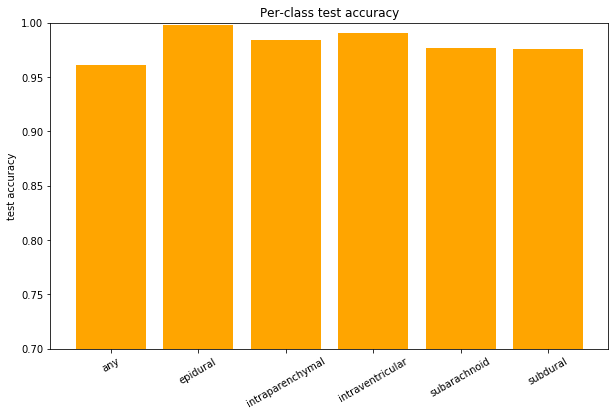

In [141]:
plt.figure(figsize=(10,6))
plt.title('Per-class test accuracy')
plt.ylabel('test accuracy')
plt.xticks(rotation=30)
axes = plt.gca()
axes.set_ylim([0.7, 1])
plt.bar(list(df['Label']), height=accuracies, color='orange')

<BarContainer object of 6 artists>

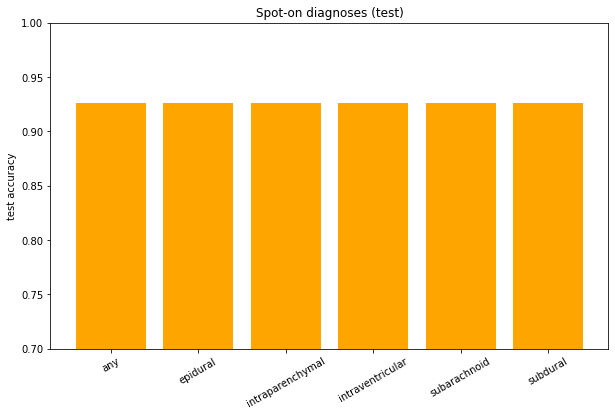

In [142]:
plt.figure(figsize=(10,6))
plt.title('Spot-on diagnoses (test)')
plt.ylabel('test accuracy')
plt.xticks(rotation=30)
axes = plt.gca()
axes.set_ylim([0.7, 1])
plt.bar(list(df['Label']), height=spot_on, color='orange')

<BarContainer object of 6 artists>

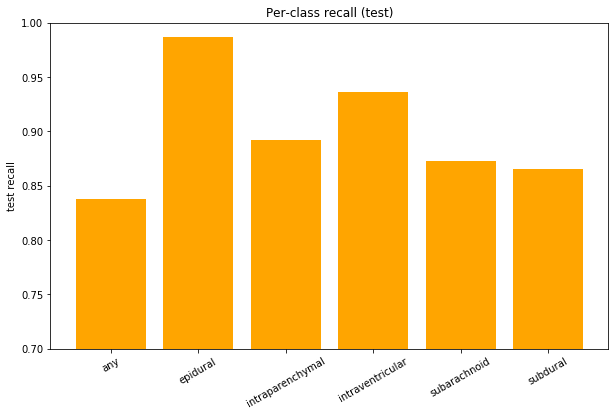

In [144]:
plt.figure(figsize=(10,6))
plt.title('Per-class recall (test)')
plt.ylabel('test recall')
plt.xticks(rotation=30)
axes = plt.gca()
axes.set_ylim([0.7, 1])
plt.bar(list(df['Label']), height=recalls, color='orange')

<BarContainer object of 6 artists>

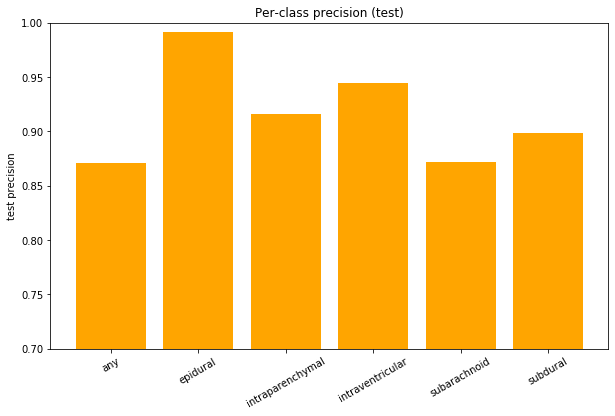

In [146]:
plt.figure(figsize=(10,6))
plt.title('Per-class precision (test)')
plt.ylabel('test precision')
plt.xticks(rotation=30)
axes = plt.gca()
axes.set_ylim([0.7, 1])
plt.bar(list(df['Label']), height=precisions, color='orange')